# Recycling Labs Framework From Libs

In [1]:
from src.preprocessing import clean_func, spacy_preprocess_reviews
from src.sts import STSAnalyzer
from src.models import BaselineModel
import numpy as np
from nltk.metrics import jaccard_distance
import os
import pandas as pd
# IMport partial
from functools import partial
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet_ic
from nltk import ngrams
brown_ic = wordnet_ic.ic('ic-brown.dat')
from nltk import download
import nltk

download('averaged_perceptron_tagger')
download('wordnet')
download('omw-1.4')
download('punkt')

import spacy
nlp = spacy.load("en_core_web_sm")
from spacy_wordnet.wordnet_annotator import WordnetAnnotator 
# Load a spaCy model (supported languages are "es" and "en") 
nlp = spacy.load('en_core_web_sm')
# spaCy 3.x
nlp.add_pipe("spacy_wordnet", after='tagger')

import textdistance
from src.fe_utils import *

prep_func = partial(spacy_preprocess_reviews, clean_func=clean_func, out_set=False)
INPUT_FOLDER = "input"
TRAIN_PATH = os.path.join(INPUT_FOLDER, "train")
TEST_PATH = os.path.join(INPUT_FOLDER, "test")
LS_FILES_TRAIN = ["MSRpar", "MSRvid", "SMTeuroparl"]
LS_FILES_TEST = ["MSRpar", "MSRvid", "SMTeuroparl", "surprise.SMTnews", "surprise.OnWN"]


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/alberto/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/alberto/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/alberto/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/alberto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/alberto/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/alberto/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/alberto/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-dat

## STS Analyzer

In [3]:
import pandas as pd
sts = STSAnalyzer(preprocess_fun=prep_func, model=BaselineModel(),
                  ls_files=LS_FILES_TRAIN, input_path=TRAIN_PATH)
df = sts.load_data()

In [11]:
def get_features(df, prep_func, clean_func, documents=None):

    print("Building auxiliary dataframes...")
    ## BUILD NECESSARY DATAFRAMES
    # Preprocess using spacy and clean and return lists
    print("- Tokenized (list)")
    df_prep_ls = df[["sent1", "sent2"]].copy()
    df_prep_ls["sent1"] = df_prep_ls["sent1"].apply(lambda x: prep_func(x, out_set=False))
    df_prep_ls["sent2"] = df_prep_ls["sent2"].apply(lambda x: prep_func(x, out_set=False))
    
    print("- Tokenized (set)")
    # Preprocess using spacy and clean and return sets
    df_prep = df_prep_ls.copy()
    df_prep["sent1"] = df_prep_ls["sent1"].apply(lambda x: set(x))
    df_prep["sent2"] = df_prep["sent2"].apply(lambda x: set(x))
    
    print("- Clean Strings")
    # Clean and return strings
    df_clean = df[["sent1", "sent2"]].copy()
    df_clean["sent1"] = df_clean["sent1"].apply(lambda x: clean_func(x))
    df_clean["sent2"] = df_clean["sent2"].apply(lambda x: clean_func(x))

    print("- Synsets")
    # Get synsets for each token
    df_synsets = df[['sent1', 'sent2']].copy()
    df_synsets = df_synsets.map(lambda x: [(token.text, token._.wordnet.synsets()) for token in nlp(x)
                                            if not token.is_stop and not token.is_punct 
                                            and not token.is_space])
    
    print("\n")
    print("Building features...")
    ## BUILD FEATURES
    df_features = pd.DataFrame()

    print("- String Similarities")
    # Get String Similarities (df_clean strings)
    df_textdistance = get_textdistance_similarities(df_clean)
    if len(df_features.columns.intersection(df_textdistance.columns)) == 0:
        df_features = pd.concat([df_features, df_textdistance], axis=1)

    print("- N-Grams Similarities")
    # Get N-Grams Similarities (df_clean strings)
    
    print("---- Use wordnet as a tokenizer")
    # ---- Use wordnet as a tokenizer
    df_ngram_sim = get_ngrams_similarities(df_clean)

    if len(df_features.columns.intersection(df_ngram_sim.columns)) == 0:
        df_features = pd.concat([df_features, df_ngram_sim], axis=1)
    
    print("---- Use spacy preprocessed as a tokenizer")
    # ---- Use spacy preprocessed data as tokens
    df_ngram_sim_spacy = get_ngrams_similarities(df_prep_ls, tokenize=False)
    df_ngram_sim_spacy.columns = [col + "_spacy" for col in df_ngram_sim_spacy.columns]

    if len(df_features.columns.intersection(df_ngram_sim_spacy.columns)) == 0:
        df_features = pd.concat([df_features, df_ngram_sim_spacy], axis=1)

    # Get Wordnet Similarities (df_synsets)
    
    print("- Wordnet Semantic Similarities")
    # These are the documents to calculate the idf. In case of train, we don't have
    # to provide it, since it will be calculated from the train data. In case of test,
    # we have to provide it, since we don't have the train data.
    
    if documents is None:
        print("---- IDF Calculation")
        documents = df_prep["sent1"].tolist() + df_prep["sent2"].tolist()

    print("---- IDF Weighted")
    # Calculate similarities, weight them with idf and average forward and backwards
    # this is mainly for asymetric similarities like Wu Palmer
    df_sem_sim = get_sem_similarities(df_synsets, idf=True, documents=documents)
    df_sem_sim.columns = [col + "_idf" for col in df_sem_sim.columns]

    if len(df_sem_sim.columns.intersection(df_features.columns)) == 0:
        df_features = pd.concat([df_features, df_sem_sim], axis=1)

    print("---- NON IDF Weighted")
    # Do the same without idf
    df_sem_sim_not_idf = get_sem_similarities(df_synsets, idf=False)
    if len(df_sem_sim_not_idf.columns.intersection(df_sem_sim_not_idf.columns)) == 0:
        df_features = pd.concat([df_features, df_sem_sim_not_idf], axis=1)
    
    return df_features
    

In [10]:
df_features_fun = get_features(df, prep_func, clean_func)
df_features_fun.describe()

,lcstr,lcseq,gst,jaro,jaro_w,monge,levenshtein,jaccard_n_1,dice_n_1,overlap_n_1,...,overlap_n_4_spacy,cosine_n_4_spacy,jaccard_n_5_spacy,dice_n_5_spacy,overlap_n_5_spacy,cosine_n_5_spacy,wup_idf,path_idf,lch_idf,lin_idf
count,2234.000000,2234.000000,2234.000000,2234.000000,2234.000000,2234.000000,2234.000000,2234.000000,2234.000000,2234.000000,...,2234.000000,2234.000000,2234.000000,2234.000000,2234.000000,2234.000000,2234.000000,2234.000000,2234.000000,2234.000000
mean,27.634288,67.973590,0.662647,0.766899,0.808289,0.027050,57.651746,0.475739,0.628661,0.681157,...,0.106649,0.094784,0.037765,0.056901,0.065774,0.057768,19.614086,16.311000,57.023453,15.274626
std,20.367231,51.836982,0.133232,0.065304,0.084370,0.145560,45.431242,0.161428,0.149015,0.157563,...,0.209811,0.187384,0.113240,0.148759,0.171762,0.150770,14.739042,13.636553,42.670331,11.969768
min,2.000000,8.000000,0.045307,0.483919,0.483919,0.002381,7.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,24.000000,0.567425,0.729399,0.747734,0.007101,22.000000,0.361111,0.530612,0.578947,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.925000,5.229037,24.737695,6.168698
50%,21.000000,57.000000,0.661087,0.765729,0.824325,0.010638,43.500000,0.458333,0.628571,0.666667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.678499,12.666907,45.934119,12.010663
75%,36.750000,95.000000,0.757000,0.800069,0.873493,0.025566,82.000000,0.578947,0.733333,0.800000,...,0.133333,0.124523,0.000000,0.000000,0.000000,0.000000,27.280856,24.089812,78.762578,21.317528
max,165.000000,334.000000,1.000000,1.000000,1.000000,2.000000,312.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,86.957049,73.770969,257.857908,71.027704


## Get Tokenization

In [13]:
# 0. Preprocess for similarity
df_prep = df.copy()
df_prep["sent1"] = df_prep["sent1"].apply(lambda x: prep_func(x, out_set=True))
df_prep["sent2"] = df_prep["sent2"].apply(lambda x: prep_func(x, out_set=True))
df_prep

,sent1,sent2,gs,file
0,"{asset, vivendi, bidder, individual, say, hope...","{vivendi, day, say, door, close, bid, source, ...",4.00,MSRpar
1,"{quarterly, profit, micron, declare, year}","{quarterly, micron, profit, dram, number, year...",3.75,MSRpar
2,"{fine, effort, entice, republican, return, for...","{fine, perry, say, effort, return, force, sena...",2.80,MSRpar
3,"{separate, authorization, represent, conservat...","{week, separate, authorization, represent, nor...",3.40,MSRpar
4,"{load, 20.96, tech, 12, month, composite, nasd...","{index, 1615.02, 19.11, lace, composite, nasda...",2.40,MSRpar
...,...,...,...,...
2229,"{item, need, quickly, agenda, action, decide, ...","{agenda, urgent, decide, item}",5.00,SMTeuroparl
2230,"{start, improvement, wish, good, believe, hone...","{well, start, good, want, actually, honestly, ...",4.80,SMTeuroparl
2231,"{amendment, parliament, accept, oral}","{amendment, parliament, accept, oral}",5.00,SMTeuroparl
2232,"{standard, concept, recognition, community, pa...","{standard, mean, legislation, concept, recogni...",4.80,SMTeuroparl


In [14]:
df_prep_ls = df.copy()
df_prep_ls["sent1"] = df_prep_ls["sent1"].apply(lambda x: prep_func(x, out_set=False))
df_prep_ls["sent2"] = df_prep_ls["sent2"].apply(lambda x: prep_func(x, out_set=False))
df_prep_ls

,sent1,sent2,gs,file
0,"[source, close, sale, say, vivendi, keep, door...","[source, close, sale, say, vivendi, keep, door...",4.00,MSRpar
1,"[micron, declare, quarterly, profit, year]","[micron, number, mark, quarterly, profit, year...",3.75,MSRpar
2,"[fine, fail, republican, effort, force, entice...","[perry, say, back, senate, effort, include, fi...",2.80,MSRpar
3,"[american, anglican, council, represent, episc...","[american, anglican, council, represent, episc...",3.40,MSRpar
4,"[tech, load, nasdaq, composite, rise, 20.96, p...","[technology, lace, nasdaq, composite, index, i...",2.40,MSRpar
...,...,...,...,...
2229,"[action, need, quickly, decide, include, item,...","[urgent, decide, item, agenda]",5.00,SMTeuroparl
2230,"[wish, improvement, honestly, believe, good, s...","[actually, want, well, think, honestly, good, ...",4.80,SMTeuroparl
2231,"[parliament, accept, oral, amendment]","[parliament, accept, oral, amendment]",5.00,SMTeuroparl
2232,"[party, reservation, community, law, apply, sa...","[party, reservation, regulation, sale, consump...",4.80,SMTeuroparl


# Clean text

In [15]:
df_clean = df.copy()
df_clean["sent1"] = df_clean["sent1"].apply(lambda x: clean_func(x))
df_clean["sent2"] = df_clean["sent2"].apply(lambda x: clean_func(x))
df_clean

,sent1,sent2,gs,file
0,but other sources close to the sale said viven...,but other sources close to the sale said viven...,4.00,MSRpar
1,micron has declared its first quarterly profit...,micron numbers also marked the first quarterly...,3.75,MSRpar
2,the fines are part of failed republican effort...,"perry said he backs the senate efforts, includ...",2.80,MSRpar
3,"the american anglican council, which represent...","the american anglican council, which represent...",3.40,MSRpar
4,the tech-loaded nasdaq composite rose 20.96 po...,the technology-laced nasdaq composite index ix...,2.40,MSRpar
...,...,...,...,...
2229,"action is needed quickly, which is why we deci...",it is urgent and that is why we have decided t...,5.00,SMTeuroparl
2230,one could indeed wish for more and for improve...,"we can actually want more and better, but i th...",4.80,SMTeuroparl
2231,(parliament accepted the oral amendment),(parliament accepted the oral amendment),5.00,SMTeuroparl
2232,- my party has serious reservations about comm...,my party serious reservations about the regula...,4.80,SMTeuroparl


## Get Synsets

In [16]:
# Calculate Synsets
df_synsets = df[['sent1', 'sent2']].copy()
df_synsets = df_synsets.map(lambda x: [(token.text, token._.wordnet.synsets()) for token in nlp(x)
                    if not token.is_stop and not token.is_punct 
                    and not token.is_space])

df_synsets.head()

,sent1,sent2
0,"[(sources, [Synset('beginning.n.04'), Synset('...","[(sources, [Synset('beginning.n.04'), Synset('..."
1,"[(Micron, [Synset('micron.n.01')]), (declared,...","[(Micron, [Synset('micron.n.01')]), (numbers, ..."
2,"[(fines, [Synset('fine.n.01')]), (failed, [Syn...","[(Perry, [Synset('perry.n.01'), Synset('perry...."
3,"[(American, [Synset('american.n.01'), Synset('...","[(American, [Synset('american.n.01'), Synset('..."
4,"[(tech, [Synset('technical_school.n.01')]), (l...","[(technology, [Synset('technology.n.01'), Syns..."


# Create Features

In [17]:
df_features = df_features_fun.copy()

In [40]:
df_stops = df_clean[["sent1", "sent2"]].copy()
df_stops["sent1"] = df_stops["sent1"].apply(lambda x: [token.text for token in nlp(x) if token.is_stop and not token.is_punct])
df_stops["sent2"] = df_stops["sent2"].apply(lambda x: [token.text for token in nlp(x) if token.is_stop and not token.is_punct])
df_stops

,sent1,sent2
0,"[but, other, to, the, was, the, to, further, a...","[but, other, to, the, was, the, for, further, ..."
1,"[has, its, first, for, three]","[also, the, first, in, three, for, the]"
2,"[the, are, part, of, to, or, the, to]","[he, the, the, to, the, to]"
3,"[the, which, it, will, to, a]","[the, which, it, will, to, a, in, because, of,..."
4,"[the, to, at, its, for]","[the, or, to]"
...,...,...
2229,"[is, which, is, why, we, to, this, on, the]","[it, is, and, that, is, why, we, have, to, put..."
2230,"[one, could, indeed, for, more, and, for, but,...","[we, can, more, and, but, i, quite, that, it, ..."
2231,[the],[the]
2232,"[my, has, serious, about, to, the, of, as, aga...","[my, serious, about, the, of, the, of, by, of,..."


In [42]:
df_ngram_stop = get_ngrams_similarities(df_stops, tokenize=False)
df_ngram_stop.columns = [col + "_stop" for col in df_ngram_stop.columns]
df_ngram_stop

,jaccard_n_1_stop,dice_n_1_stop,overlap_n_1_stop,cosine_n_1_stop,jaccard_n_2_stop,dice_n_2_stop,overlap_n_2_stop,cosine_n_2_stop,jaccard_n_3_stop,dice_n_3_stop,overlap_n_3_stop,cosine_n_3_stop,jaccard_n_4_stop,dice_n_4_stop,overlap_n_4_stop,cosine_n_4_stop,jaccard_n_5_stop,dice_n_5_stop,overlap_n_5_stop,cosine_n_5_stop
0,0.500000,0.666667,0.700000,0.667424,0.263158,0.416667,0.416667,0.416667,0.222222,0.363636,0.363636,0.363636,0.176471,0.3,0.3,0.300000,0.125000,0.222222,0.222222,0.222222
1,0.375000,0.545455,0.600000,0.547723,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.285714,0.444444,0.666667,0.471405,0.100000,0.181818,0.250000,0.188982,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.600000,0.750000,1.000000,0.774597,0.555556,0.714286,1.000000,0.745356,0.500000,0.666667,1.000000,0.707107,0.428571,0.6,1.0,0.654654,0.333333,0.500000,1.000000,0.577350
4,0.333333,0.500000,0.666667,0.516398,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2229,0.538462,0.700000,0.875000,0.714435,0.250000,0.400000,0.500000,0.408248,0.125000,0.222222,0.285714,0.227921,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2230,0.411765,0.583333,0.636364,0.585369,0.095238,0.173913,0.200000,0.175412,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2231,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2232,0.636364,0.777778,0.777778,0.777778,0.222222,0.363636,0.400000,0.365148,0.045455,0.086957,0.100000,0.087706,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


In [43]:
if len(df_features.columns.intersection(df_ngram_stop.columns)) == 0:
    df_features = pd.concat([df_features, df_ngram_stop], axis=1)

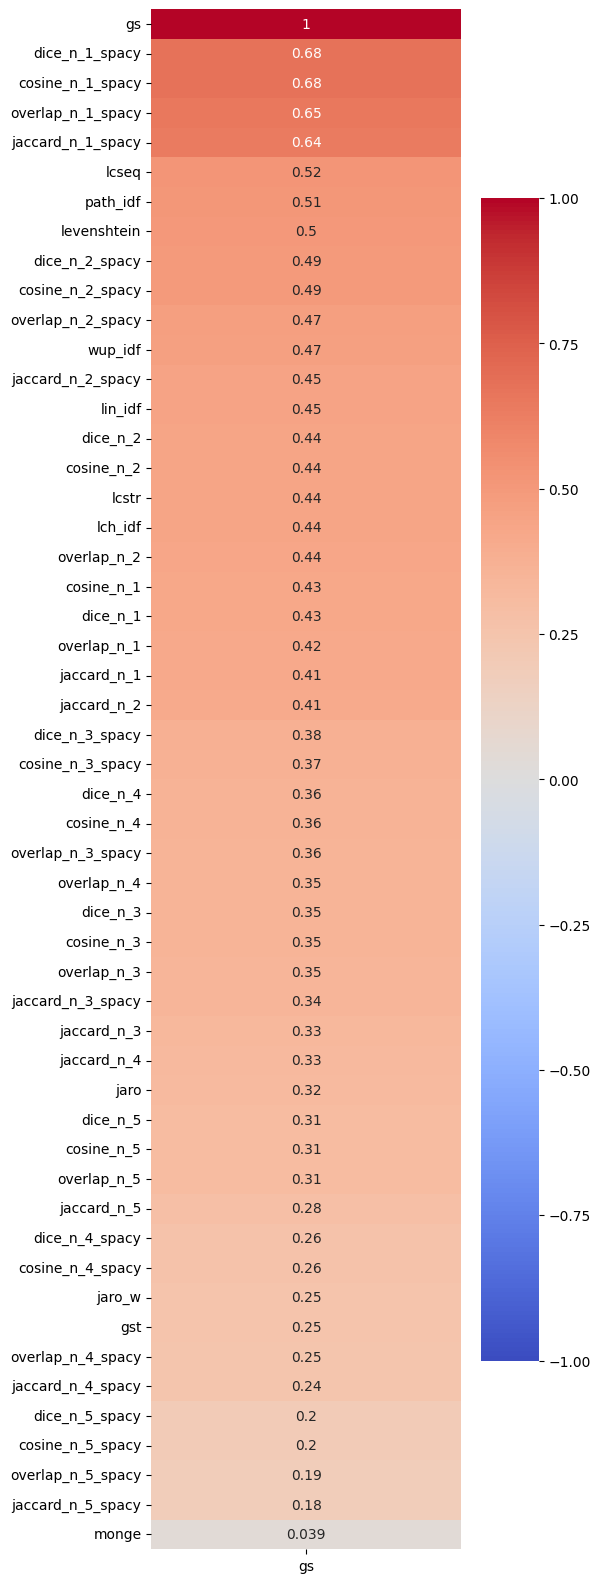

In [18]:

df_corr = pd.concat([df_features, df_prep["gs"]], axis=1)

# Plot heatmap of correlations
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
df_corr = pd.DataFrame(sc.fit_transform(df_corr), columns=df_corr.columns)
plt.figure(figsize=(5, 20))
sns.heatmap(df_corr.corr()[["gs"]].sort_values(by="gs", ascending=False), annot=True, cmap="coolwarm", label="big",
            vmin=-1, vmax=1)
plt.show()


In [ ]:
df_feats_par = df_features[df["file"] == "MSRpar"]
df_feats_vid = df_features[df["file"] == "MSRvid"]
df_feats_euro = df_features[df["file"] == "SMTeuroparl"]

y_par = df[df["file"] == "MSRpar"]["gs"]
y_vid = df[df["file"] == "MSRvid"]["gs"]
y_euro = df[df["file"] == "SMTeuroparl"]["gs"]

In [56]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from scipy.stats import pearsonr

rf_par= RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, min_samples_leaf=6)

# Create a scorer usin pearson correlation
pearson_scorer = make_scorer(lambda x, y: pearsonr(x, y).statistic)

scores_par = cross_val_score(rf_par, df_feats_par, y_par, cv=10, scoring=pearson_scorer)
rf_par.fit(df_feats_par, y_par)
print("Pearson correlation: %0.2f (+/- %0.2f)" % (scores_par.mean(), scores_par.std() * 2))

Pearson correlation: 0.66 (+/- 0.11)


In [57]:
rf_vid = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, min_samples_leaf=6)

# Create a scorer usin pearson correlation
pearson_scorer = make_scorer(lambda x, y: pearsonr(x, y).statistic)

scores_vid = cross_val_score(rf_vid, df_feats_vid, y_vid, cv=10, scoring=pearson_scorer)
rf_vid.fit(df_feats_vid, y_vid)
print("Pearson correlation: %0.2f (+/- %0.2f)" % (scores_vid.mean(), scores_vid.std() * 2))

Pearson correlation: 0.81 (+/- 0.07)


In [63]:
rf_euro = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, min_samples_leaf=3)

# Create a scorer usin pearson correlation
pearson_scorer = make_scorer(lambda x, y: pearsonr(x, y).statistic)

scores_euro = cross_val_score(rf_euro, df_feats_euro, y_euro, cv=10, scoring=pearson_scorer)
rf_euro.fit(df_feats_euro, y_euro)
print("Pearson correlation: %0.2f (+/- %0.2f)" % (scores_euro.mean(), scores_euro.std() * 2))

Pearson correlation: 0.70 (+/- 0.29)


In [64]:
scores_euro

array([0.71083292, 0.58067859, 0.83537188, 0.89908301, 0.7803359 ,
       0.41436774, 0.62335735, 0.74882944, 0.56660093, 0.85696031])

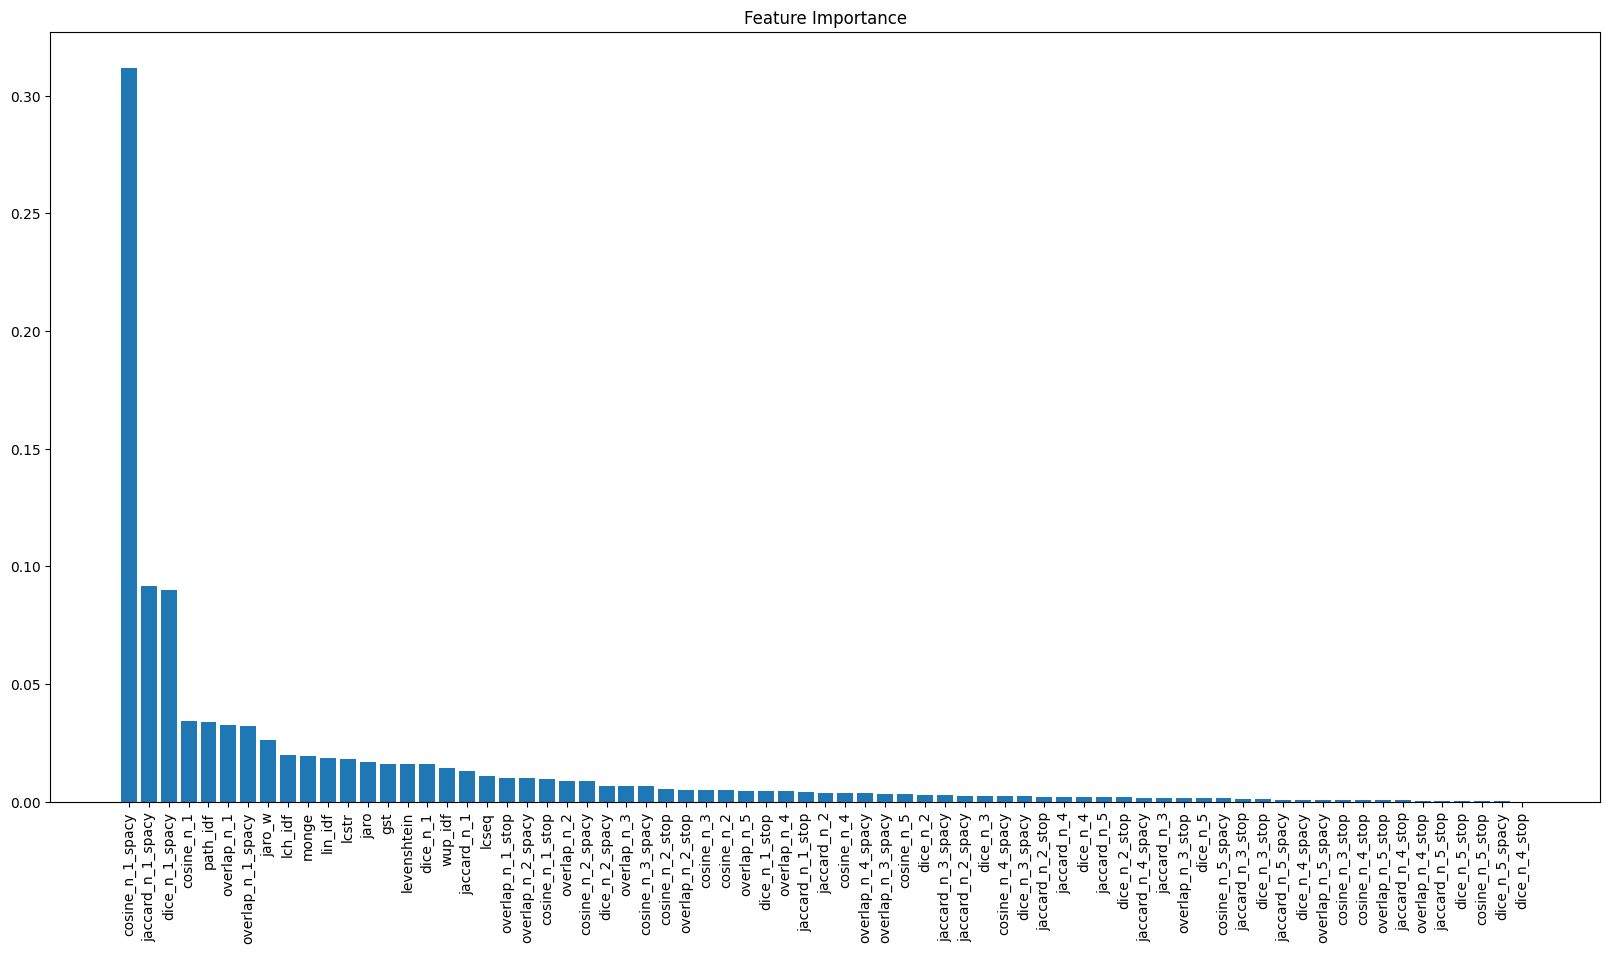

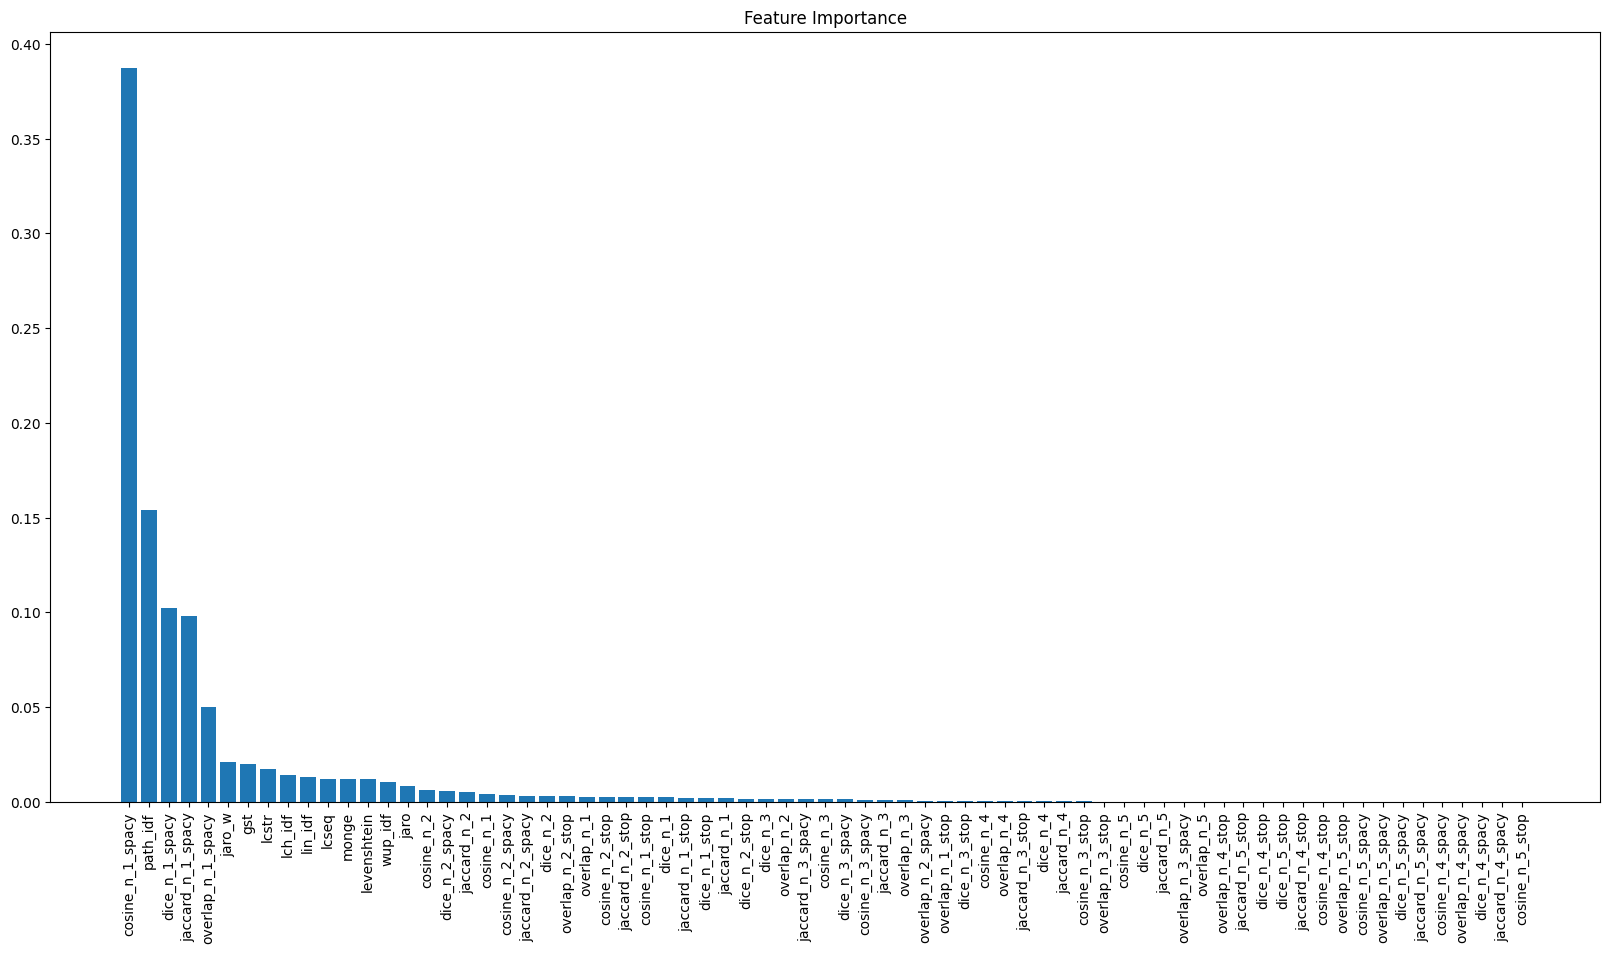

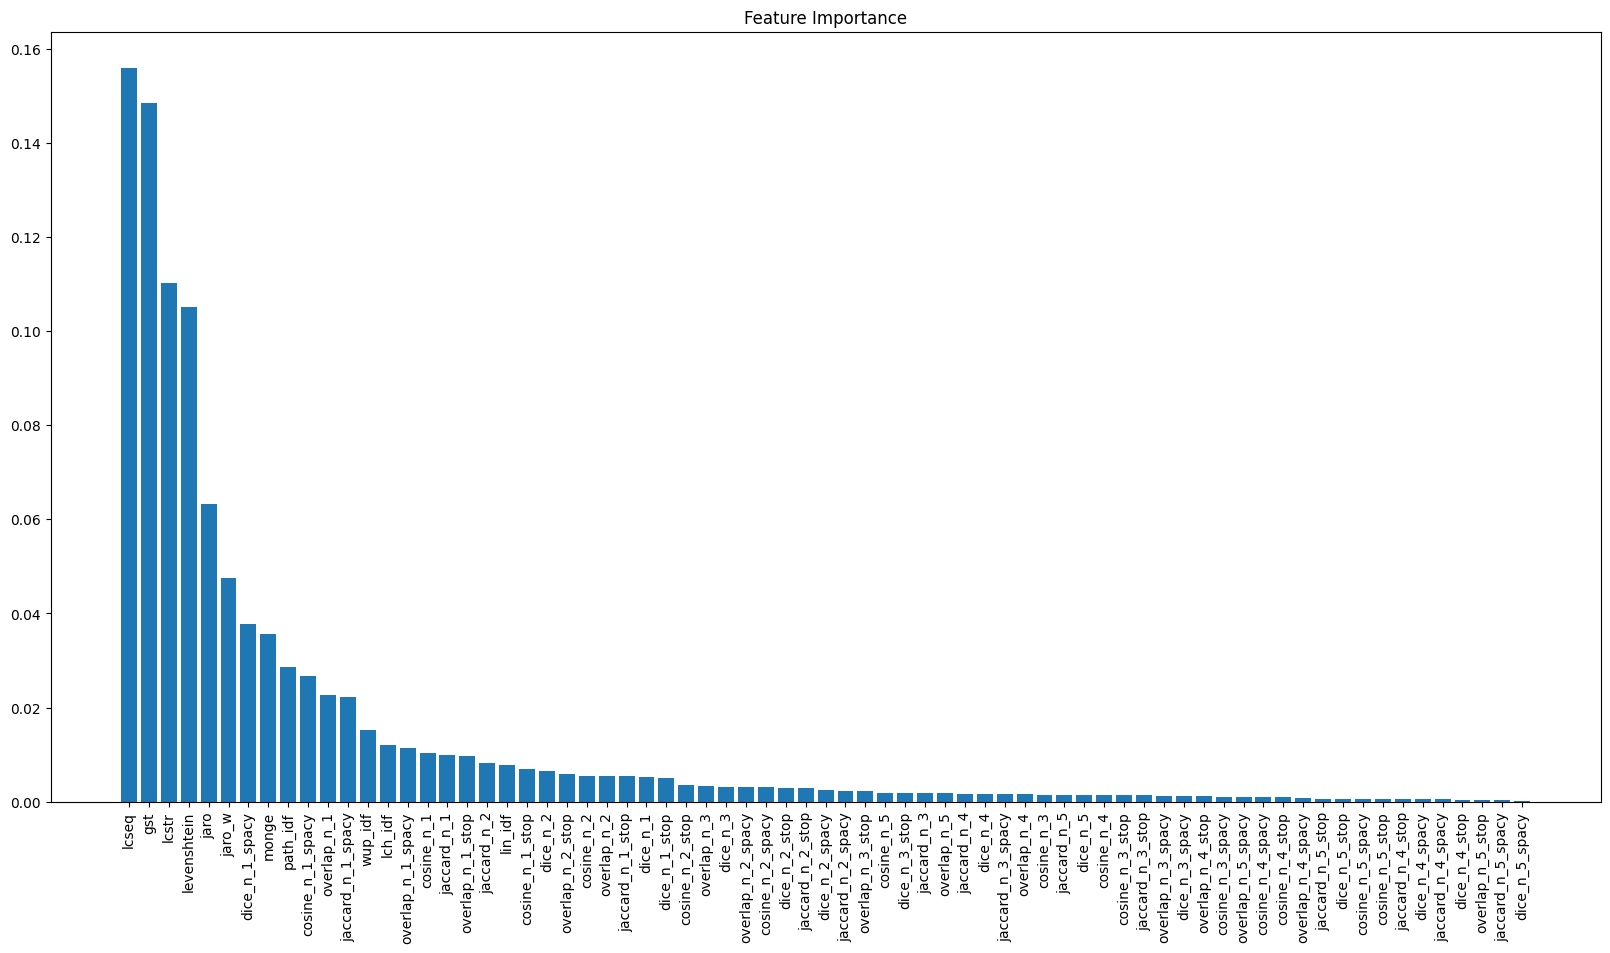

In [65]:
# Create a function receiving a trained rf and plots the feature importances
def plot_feature_importances(rf, df):
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    names = [df.columns[i] for i in indices]
    plt.figure(figsize=(20, 10))
    plt.title("Feature Importance")
    plt.bar(range(df.shape[1]), importances[indices])
    plt.xticks(range(df.shape[1]), names, rotation=90)
    plt.show()

plot_feature_importances(rf_par, df_feats_par)
plot_feature_importances(rf_vid, df_feats_vid)

plot_feature_importances(rf_euro, df_feats_euro)

In [ ]:
# import umap
# reduce = umap.UMAP()